In [1]:
import os, warnings, folium
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances, mean_squared_error
from sklearn.preprocessing import minmax_scale, MultiLabelBinarizer
from sklearn.decomposition import NMF
from random import randint

# Pandas and Numpy configs
pd.set_option('display.max_columns', 20)
np.set_printoptions(suppress=True)

# Input data files are available in the "../content/" directory.
main_path = '/content'

# Init ploty in offline mode
plot_template = 'plotly_white'

warnings.filterwarnings('ignore')


In [3]:
!pip install --upgrade pip
!pip install --upgrade setuptools

## Loading Data
Let's load data into the <code>raw</code> dataframe. The dataset contains photo records including meta tags related to photos and users who took them.

In [39]:
### Path of file to read
data_file_path = f'{main_path}/sample_data/london_20k.csv'

# Changing data types
data_type = {
    'photo_id': 'object',
    'owner': 'object',
    'faves': 'float16',
    'lat': 'float32',
    'lon': 'float32',
    'taken': 'datetime64'
}

# Reading file into a variable data
raw = pd.read_csv(data_file_path,
                  engine='python',
                  sep=',',
                  encoding='utf-8',
                  dtype=data_type,
                  decimal=',')
data_dim = raw.shape

print(f'Dataframe dimentions: {data_dim}', f'\n{"-"*50}\nData Types:\n{raw.dtypes}')

# Show head
raw.head()

Dataframe dimentions: (20000, 13) 
--------------------------------------------------
Data Types:
photo_id               object
owner                  object
gender                float64
occupation             object
title                  object
description            object
tags                   object
faves                 float16
lat                   float32
lon                   float32
u_city                 object
u_country              object
taken          datetime64[ns]
dtype: object


,photo_id,owner,gender,occupation,title,description,tags,faves,lat,lon,u_city,u_country,taken
0,12056545693,78191777@N00,1.0,Producer/DJ,près,<i>Let us draw near with a true heart in full ...,"clapham, london, england, ukgarage, dubstep, e...",0.0,51.465164,-0.129085,30307,USA,2014-01-20 15:19:44
1,12453639663,41087279@N00,1.0,Accountant,DSC_4241 Chyna Whyne from Jamaica Live at Char...,Chyna Whyne from Jamaica Live at Charlie Wrigh...,"chyna, whyne, from, jamaica, live, charlie, wr...",1.0,51.527672,-0.083648,London,England,2014-02-09 23:05:35
2,13185773995,41087279@N00,1.0,Accountant,DSC_6178 Flirt 69 Birthday Party at Charlie Wr...,Flirt 69 Birthday Party at Charlie Wrights Mus...,"flirt, 69, birthday, party, charlie, wrights, ...",0.0,51.527672,-0.083648,London,England,2014-03-14 22:24:02
3,13295046445,30625665@N00,1.0,NaN,Bank Limited,BREAKING NEWS My 806th picture to be viewed ov...,"bank, ex, cash, point, atm, brick, stone, lond...",5.0,51.513042,-0.089221,NaN,NaN,2014-03-20 09:13:03
4,13357656115,41087279@N00,1.0,Accountant,DSC_6743 Ray Estaire Live at Charlie Wrights M...,Ray Estaire Live at Charlie Wrights Music Loun...,"ray, estaire, jazz, ensemble, the, dominant, 7...",1.0,51.527672,-0.083648,London,England,2014-03-21 23:18:39


## Data Validation
In this step, we find and remove rows including coordinates (latitude and longitude) with <code>NA</code>/<code>Null</code> value.

In [40]:
# Finding total missing values
data = raw[['photo_id','owner','lat','lon','taken']]
missing_nan = data.isna().sum()

print('TOTAL MISSINGS:', missing_nan, sep='\n')

# Removing missing values
data = data.dropna(subset=['lat','lon'])
new_size = len(data.index)
print(f'{"-"*50}\n{data_dim[0]-new_size} empty rows are removed.')

TOTAL MISSINGS:
photo_id    0
owner       0
lat         0
lon         0
taken       0
dtype: int64
--------------------------------------------------
0 empty rows are removed.


In [41]:
data

,photo_id,owner,lat,lon,taken
0,12056545693,78191777@N00,51.465164,-0.129085,2014-01-20 15:19:44
1,12453639663,41087279@N00,51.527672,-0.083648,2014-02-09 23:05:35
2,13185773995,41087279@N00,51.527672,-0.083648,2014-03-14 22:24:02
3,13295046445,30625665@N00,51.513042,-0.089221,2014-03-20 09:13:03
4,13357656115,41087279@N00,51.527672,-0.083648,2014-03-21 23:18:39
...,...,...,...,...,...
19995,48703948963,56435084@N04,51.508251,-0.075003,2019-08-21 14:06:44
19996,6393809459,29057345@N04,51.513592,-0.099735,2014-04-17 12:00:38
19997,6516141445,33264177@N05,51.494328,-0.185072,2015-01-01 00:00:00
19998,6603467827,33264177@N05,51.517181,-0.077226,2015-01-01 00:00:00


**Finding How the Data distributes**

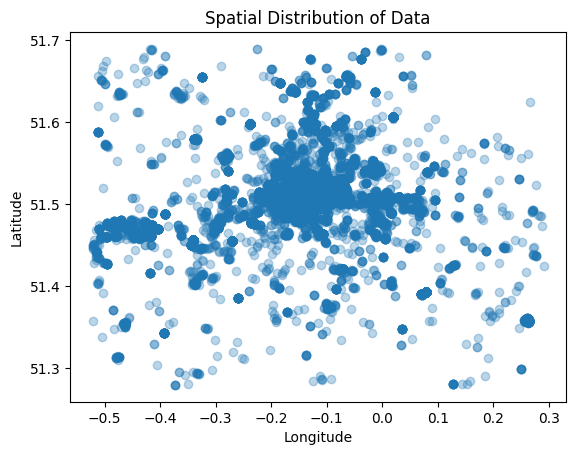

In [7]:
import matplotlib.pyplot as plt

# Assuming 'lat' and 'lon' are the columns containing latitude and longitude
plt.scatter(data['lon'], data['lat'], alpha=0.3)
plt.title('Spatial Distribution of Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finding DBSCAN Parameters



In [8]:
# Creating dataframe filled with DBSCAN params and clusters
# Init ploty in offline mode
plot_template = 'plotly_white'
def paramsClusters(data, eps_range, minPts_range):
    m_per_rad = 6371.0088 * 1000
    df = pd.DataFrame(columns=['eps','min_pts','num_clusters'])
    for m in minPts_range:
        for e in eps_range:
            eps_rad = e/m_per_rad
            eps_rad = eps_rad
            #  DBSCAN based on Haversine metric
            db = DBSCAN(eps=eps_rad, min_samples=m, algorithm='ball_tree', metric='haversine').fit(np.radians(data[['lat','lon']]))
            c = len(set(db.labels_ + 1))
            df = df.append({'eps': e, 'min_pts': m, 'num_clusters': c}, ignore_index=True)

    return df

# DBSCAN trend - epsilons and clusters
epsilons = list(map(lambda n: n*20, range(1,16)))
min_points = list(map(lambda n: n*10, range(1,6)))
pc = paramsClusters(data, epsilons, min_points)
EVC = go.Figure()

for m in pc.min_pts.unique():
    df = pc[pc.min_pts == m]
    EVC.add_trace(go.Scatter(
        x=df.eps,
        y=df.num_clusters,
        name=f'Min Samples: {m} points',
        mode='lines+markers',
        marker=dict(size=8),
        line=dict(width=2),
        line_shape='spline'
    ))

EVC.update_layout(
    title='The number of detected clusters with different valuses of MinSamples',
    xaxis=dict(title='Epsilon', zeroline=False, dtick=40),
    yaxis=dict(title='Number of Cluster', zeroline=False),
    template=plot_template
)

# DBSCAN trend - samples and clusters
epsilons = list(map(lambda n: n*20, range(1,5)))
min_points = list(map(lambda n: n*5, range(1,11)))
pc = paramsClusters(data, epsilons, min_points)
MVC = go.Figure()

for e in pc.eps.unique():
    df = pc[pc.eps == e]
    MVC.add_trace(go.Scatter(
        x=df.min_pts,
        y=df.num_clusters,
        name=f'Epsilon: {e} m',
        mode='lines+markers',
        marker=dict(size=8),
        line=dict(width=2),
        line_shape='spline'
    ))

MVC.update_layout(
    title='The number of detected clusters with different valuses of Eps',
    xaxis=dict(title='The number of samples in neighborhood', zeroline=False, dtick=5),
    yaxis=dict(title='Number of Cluster', zeroline=False),
    template=plot_template
)

EVC.show()
MVC.show()

In [11]:
df

,eps,min_pts,num_clusters
3,80,5,458
7,80,10,244
11,80,15,176
15,80,20,145
19,80,25,126
23,80,30,98
27,80,35,93
31,80,40,84
35,80,45,78
39,80,50,65


In [17]:
data.loc[:, {'lat','lon'}]


,lat,lon
0,51.465164,-0.129085
1,51.527672,-0.083648
2,51.527672,-0.083648
3,51.513042,-0.089221
4,51.527672,-0.083648
...,...,...
19995,51.508251,-0.075003
19996,51.513592,-0.099735
19997,51.494328,-0.185072
19998,51.517181,-0.077226


from matplotlib import pyplot as plt
_df_0['lat'].plot(kind='hist', bins=20, title='lat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['lon'].plot(kind='hist', bins=20, title='lon')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='lat', y='lon', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['lat'].plot(kind='line', figsize=(8, 4), title='lat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['lon'].plot(kind='line', figsize=(8, 4), title='lon')
plt.gca().spines[['top', 'right']].set_visible(False)

## DBSCAN
We choose <code>eps = 120</code> and <code>min_sample = 10</code> to the data.

In [18]:
# Calculating DBSCAN based on Haversine metric
def HDBSCAN(df, epsilon, minPts, x='lat', y='lon'):

    # Finding most centered sample in a cluster
    def getCenterMostPts(cluster):
        centroid = (MultiPoint(cluster.values).centroid.x, MultiPoint(cluster.values).centroid.y)
        centermost_point = min(cluster.values, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

    m_per_rad = 6371.0088 * 1000
    eps_rad = epsilon/m_per_rad
    photo_coords = df.loc[:, {x,y}]
    photo_coords = photo_coords[['lat','lon']]
    db = DBSCAN(eps=eps_rad, min_samples=minPts, algorithm='ball_tree', metric='haversine').fit(np.radians(photo_coords))
    cluster_labels = db.labels_ + 1
    num_clusters = len(set(cluster_labels))

    # Putting clusters and their subset of coords in an array
    clusters = pd.Series([photo_coords[cluster_labels==n] for n in range(num_clusters)])

    # Finding centroid of each cluster
    centroids = clusters.map(getCenterMostPts)

    # Pulling rows from original data frame where row numbers match the clustered data
    rows = clusters.apply(lambda c: c.index.values)
    clustered_df = rows.apply(lambda row_num: df.loc[row_num])

    # Appending cluster numbers and centroid coords to each clustered dataframe
    lats,lons = zip(*centroids)
    new_df = []
    for i, v in clustered_df.iteritems():
        v.loc[:, 'cluster_num'] = i
        v.loc[:, 'cent_lat'] = lats[i]
        v.loc[:, 'cent_lon'] = lons[i]
        new_df.append(v)
    new_df = pd.concat(new_df)

    return new_df

cdata = HDBSCAN(data, epsilon=120, minPts=10)
print(f'Number of clusters: {len(cdata.cluster_num.unique())}')

Number of clusters: 195


In [20]:
cdata

,photo_id,owner,lat,lon,taken,cluster_num,cent_lat,cent_lon
0,12056545693,78191777@N00,51.465164,-0.129085,2014-01-20 15:19:44,0,51.506939,-0.152331
6,13981004399,41087279@N00,51.502697,-0.188376,2014-05-11 01:02:56,0,51.506939,-0.152331
8,14164690032,41087279@N00,51.502697,-0.188376,2014-05-11 01:00:30,0,51.506939,-0.152331
9,14164957612,41087279@N00,51.502697,-0.188376,2014-05-11 01:02:42,0,51.506939,-0.152331
14,14365757571,95796241@N02,51.677612,-0.431470,2014-04-17 11:40:00,0,51.506939,-0.152331
...,...,...,...,...,...,...,...,...
19848,48687135672,133813370@N04,51.470535,-0.404552,2019-08-26 16:24:24,194,51.470535,-0.404552
19855,48687482592,133813370@N04,51.470535,-0.404552,2019-08-26 14:07:30,194,51.470535,-0.404552
19857,48687563057,133813370@N04,51.470535,-0.404552,2019-08-26 14:45:49,194,51.470535,-0.404552
19858,48687563122,133813370@N04,51.470535,-0.404552,2019-08-26 14:42:38,194,51.470535,-0.404552


## Clustering

In [42]:
import pandas as pd

# Assuming 'lat', 'lon', 'cluster_num', and 'photo_num' are the column names in your DataFrame cdata
# Modifying them based on our actual DataFrame structure

def matplotlibToPlotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append('rgb'+str((C[0], C[1], C[2])))

    return pl_colorscale

# Creating a new DataFrame to store lat, lon, cluster_num, and photo_num
stored_data = pd.DataFrame(columns=['lat', 'lon', 'cluster_num', 'photo_num'])

unique_labels = cdata.cluster_num.unique()
colors = matplotlibToPlotly(plt.cm.Spectral, len(unique_labels))
DB = go.Figure()
leaflet_map = folium.Map(location=[51.514205, -0.104371], zoom_start=12, tiles='Cartodb Positron')

for k, col in zip(unique_labels, colors):
    # Check if label number is 0, then create noisy points
    if k == 0:
        col = 'gray'
        df = cdata[cdata.cluster_num == 0]

        # Store lat, lon, cluster_num, and photo_num in the new DataFrame
        stored_data = stored_data.append({'lat': df.lat.values[0],
                                          'lon': df.lon.values[0],
                                          'cluster_num': k,
                                          'photo_num': len(df)},
                                         ignore_index=True)

        DB.add_trace(go.Scatter(
            x=df.lat,
            y=df.lon,
            mode='markers',
            name='noise',
            marker=dict(size=3, color=col),
            hoverinfo='none'
        ))

    # Checking the remaining clusters
    else:
        col = col
        df = cdata[cdata.cluster_num == k]
        lat = df.lat
        lon = df.lon
        cent_lat = df.cent_lat.unique()
        cent_lon = df.cent_lon.unique()

        # Storing lat, lon, cluster_num, and photo_num in the new DataFrame
        stored_data = stored_data.append({'lat': lat.values[0],
                                          'lon': lon.values[0],
                                          'cluster_num': k,
                                          'photo_num': len(df)},
                                         ignore_index=True)

        # Bokeh plot
        DB.add_trace(go.Scatter(
            x=lat,
            y=lon,
            mode='markers',
            name='point',
            marker=dict(size=5, color=col),
            text=df.photo_id.apply(lambda id: f'photo_id: {id}'),
            hoverinfo='none',
            showlegend=False
        ))
        DB.add_trace(go.Scatter(
            x=cent_lat,
            y=cent_lon,
            mode='markers',
            name='centroid',
            text=f'cluster: {k}',
            marker=dict(
                size=12,
                color=col,
                line=dict(color='gray', width=1)
            ),
            hoverinfo='x+y+name+text'
        ))

        # Map plot
        folium.Marker(
            location=[cent_lat, cent_lon],
            icon=folium.Icon(icon='map-marker')
        ).add_to(leaflet_map)

# Displaying or saving the stored_data DataFrame as needed
print(stored_data)

DB.update_layout(
    title='DBSCAN based on Haversine including center most points',
    hovermode='closest',
    showlegend=False,
    xaxis=dict(title='Latitude', zeroline=False),
    yaxis=dict(title='Longitude', zeroline=False),
    template=plot_template
)

DB.show()
leaflet_map


           lat       lon  cluster_num  photo_num
0    51.465164 -0.129085          0.0     3604.0
1    51.527672 -0.083648          1.0      418.0
2    51.513042 -0.089221          2.0     5175.0
3    51.533535 -0.123067          3.0      251.0
4    51.541504 -0.146770          4.0      101.0
..         ...       ...          ...        ...
190  51.502987 -0.082215        190.0       10.0
191  51.508270  0.046606        191.0       16.0
192  51.491879 -0.018864        192.0       11.0
193  51.475101 -0.414445        193.0       30.0
194  51.470535 -0.404552        194.0       53.0

[195 rows x 4 columns]


**Cluster Analysis**

In [25]:
# Removing noise cluster from the training set
clean_data = cdata[cdata.cluster_num!=0]

# Distribution plot
def chunk(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

distrib_df = clean_data.groupby(['cluster_num'])['cluster_num'].count().reset_index(name='photo_num')
chunked_distrib = chunk(distrib_df, 50)

for df in chunked_distrib:
    cluster_distrib = go.Figure([go.Bar(x=df.cluster_num, y=df.photo_num)])
    cluster_distrib.update_layout(
        title='Distribution of photos among clusters',
        xaxis=dict(title='Cluster id', dtick=1),
        yaxis=dict(title='Number of images'),
        template=plot_template
    )
    cluster_distrib.show()

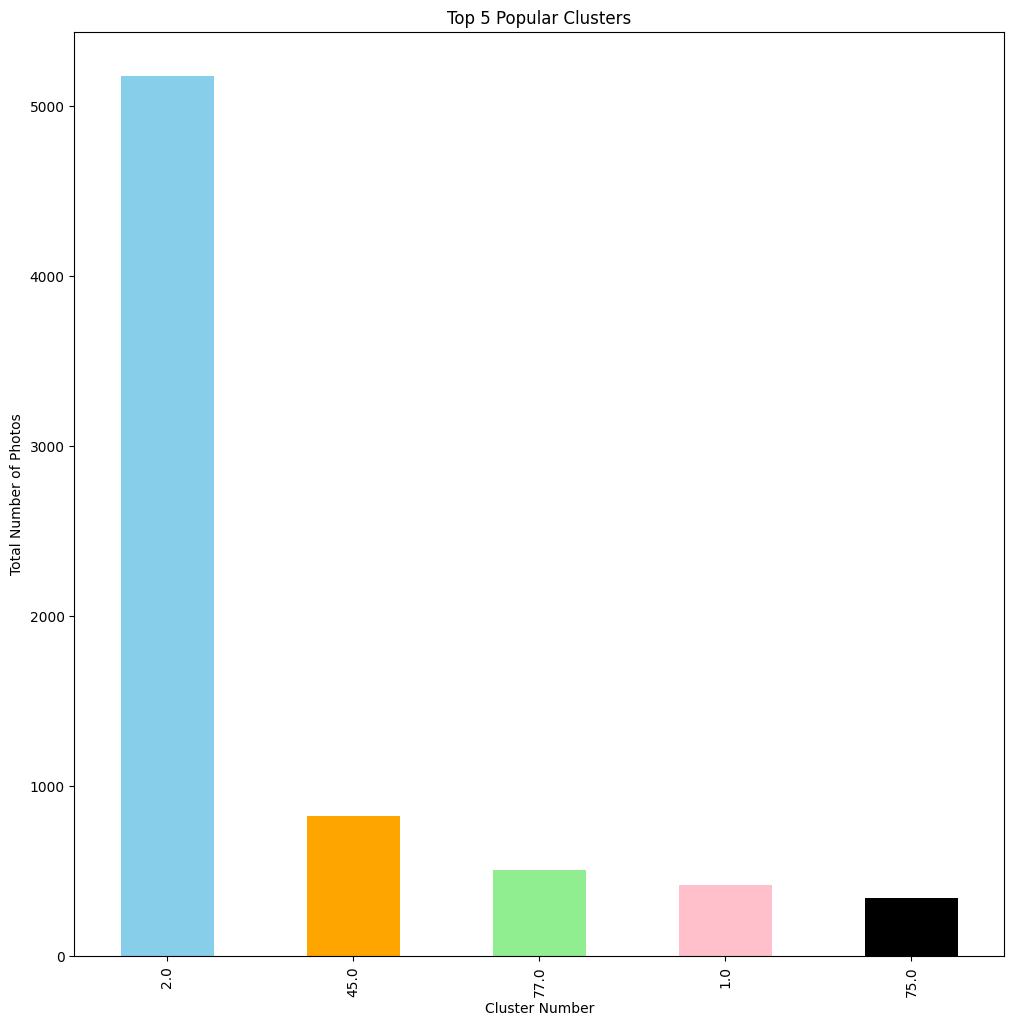

In [26]:
# Assuming 'photo_num' is the column containing the number of photos in each cluster
stored_data = stored_data.dropna()

# Excluding cluster number 0.0
top5_locations = stored_data[stored_data['cluster_num'] != 0.0].nlargest(5, 'photo_num')

# Visualizing the result for the top 5 places
plt.figure(figsize=(12, 12))
top5_locations.set_index('cluster_num')['photo_num'].plot(kind='bar', color=['skyblue', 'orange', 'lightgreen', 'pink', 'black'])
plt.title("Top 5 Popular Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Total Number of Photos")
plt.show()


**Data Visualization**

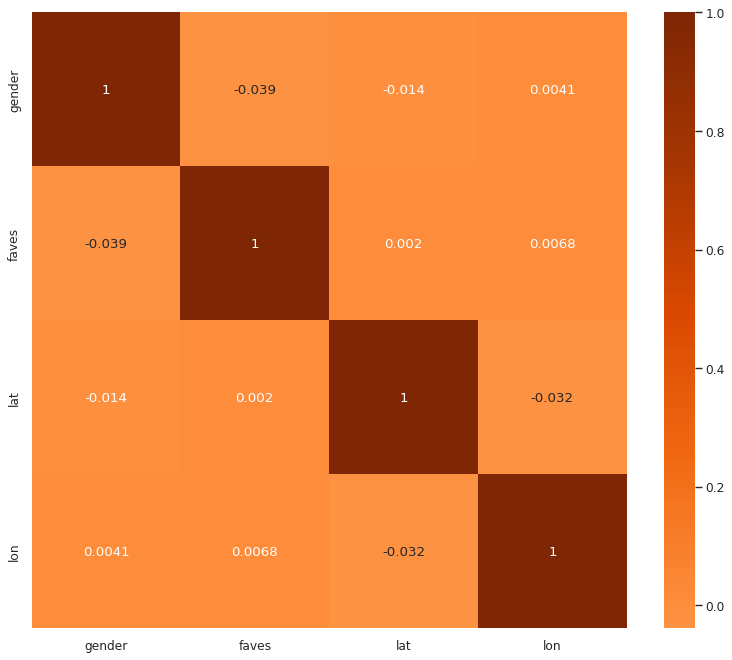

In [43]:
import seaborn as sns

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(raw.corr(),cmap='Oranges', center=0, annot=True) # visual

plt.show()

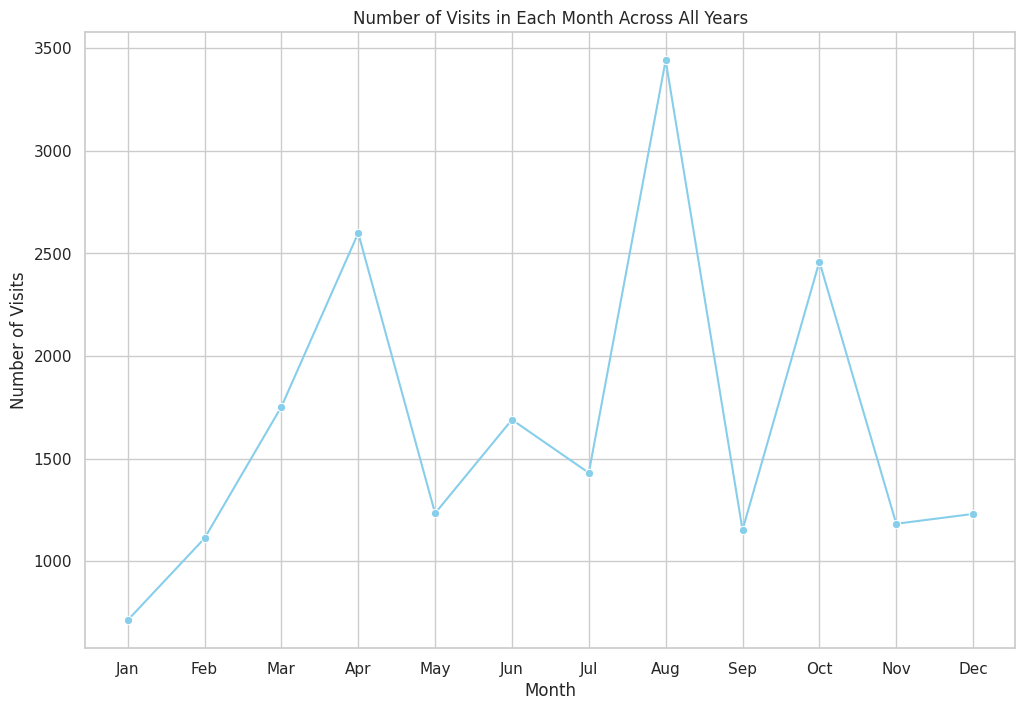

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns



sns.set(style="whitegrid")

# Extracting the month abbreviation from the 'taken' column
data['month_abbr'] = raw['taken'].dt.strftime('%b')

# Defining the order of the month abbreviations
month_order = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]

# Grouping by the month abbreviation and count the number of visits
num_visits_per_month = data['month_abbr'].value_counts().sort_index()

# Reordering the month abbreviations
num_visits_per_month = num_visits_per_month.reindex(month_order, fill_value=0)

plt.figure(figsize=(12, 8))
sns.lineplot(x=num_visits_per_month.index, y=num_visits_per_month.values, marker='o', color='skyblue')
plt.title('Number of Visits in Each Month Across All Years')
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.show()


month
1     125
2     140
3     210
4     357
5     212
6     178
7     170
8     315
9     182
10    175
11    123
12    136
Name: owner, dtype: int64


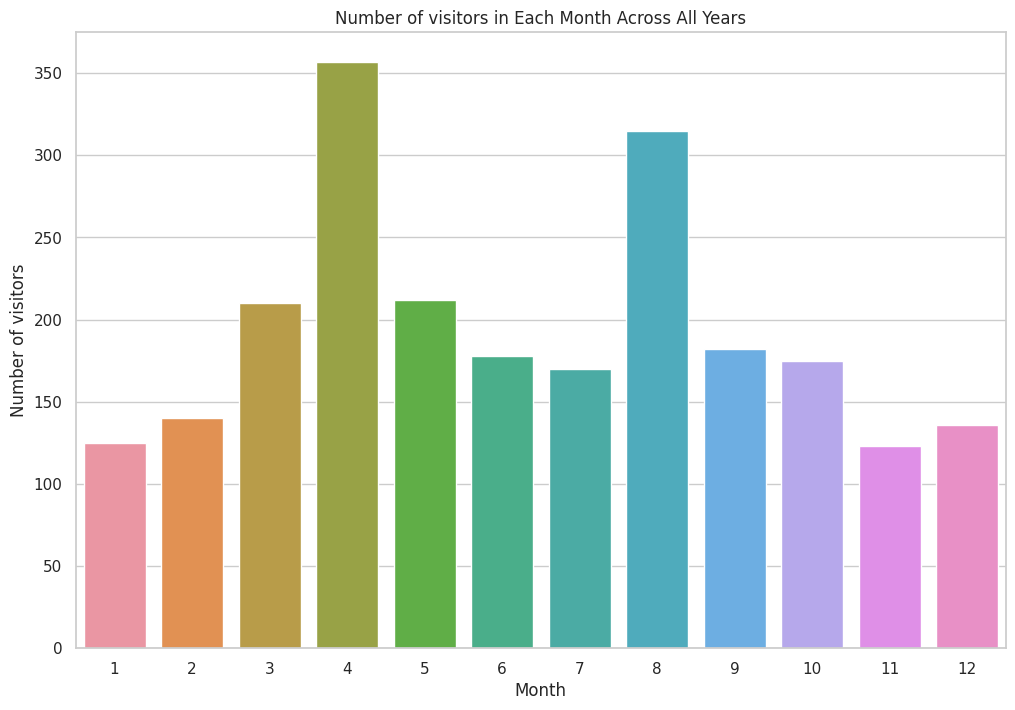

In [45]:
import pandas as pd


# Set the timestamp column as the index
data['month'] = raw['taken'].dt.month

# Group by month and count the number of unique owners
owners_by_month = data.groupby('month')['owner'].nunique()



print(owners_by_month)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.barplot(x=owners_by_month.index, y=owners_by_month.values)
plt.title('Number of visitors in Each Month Across All Years')
plt.xlabel('Month')
plt.ylabel('Number of visitors')
plt.show()


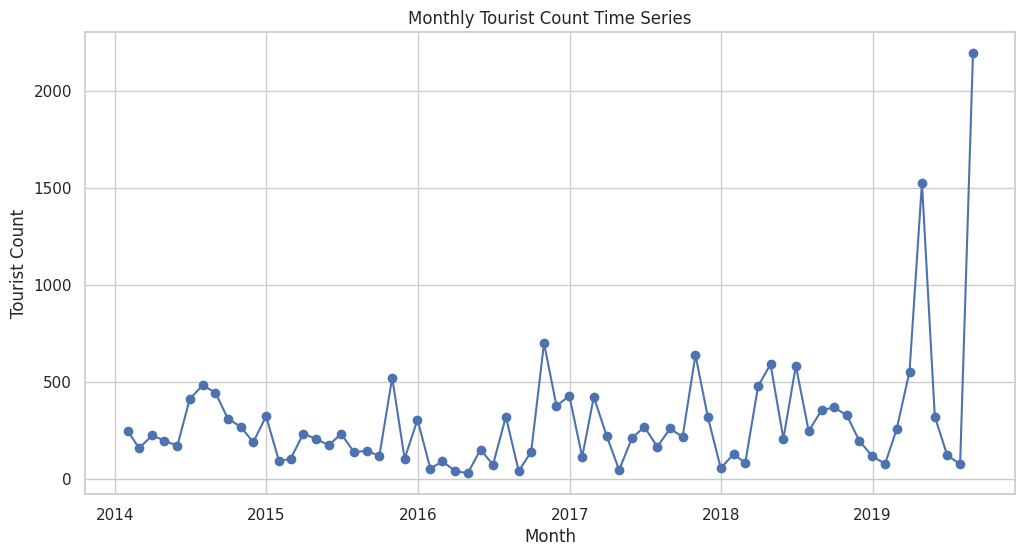

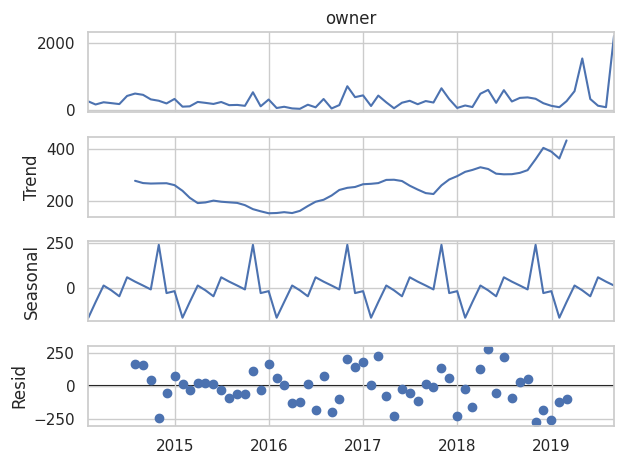

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# Set the timestamp column as the index
data = raw.set_index('taken')

# Resample the data on a monthly basis and count the number of visitors
monthly_data = data['owner'].resample('M').count()

# Fill missing months (optional)
monthly_data = monthly_data.reindex(pd.date_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='M'))

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, marker='o')
plt.title('Monthly Tourist Count Time Series')
plt.xlabel('Month')
plt.ylabel('Tourist Count')
plt.grid(True)
plt.show()

# Decompose the time series to understand its components (trend, seasonality, residual)
result = seasonal_decompose(monthly_data, model='additive', period=12)
result.plot()
plt.show()





## **Forecasting Tourist Count**

**LSTM**

Epoch 1/100
5/5 - 1s - loss: 0.3851 - 1s/epoch - 274ms/step
Epoch 2/100
5/5 - 0s - loss: 0.3794 - 34ms/epoch - 7ms/step
Epoch 3/100
5/5 - 0s - loss: 0.3716 - 25ms/epoch - 5ms/step
Epoch 4/100
5/5 - 0s - loss: 0.3664 - 25ms/epoch - 5ms/step
Epoch 5/100
5/5 - 0s - loss: 0.3612 - 25ms/epoch - 5ms/step
Epoch 6/100
5/5 - 0s - loss: 0.3544 - 22ms/epoch - 4ms/step
Epoch 7/100
5/5 - 0s - loss: 0.3491 - 22ms/epoch - 4ms/step
Epoch 8/100
5/5 - 0s - loss: 0.3435 - 22ms/epoch - 4ms/step
Epoch 9/100
5/5 - 0s - loss: 0.3368 - 22ms/epoch - 4ms/step
Epoch 10/100
5/5 - 0s - loss: 0.3331 - 25ms/epoch - 5ms/step
Epoch 11/100
5/5 - 0s - loss: 0.3254 - 24ms/epoch - 5ms/step
Epoch 12/100
5/5 - 0s - loss: 0.3209 - 27ms/epoch - 5ms/step
Epoch 13/100
5/5 - 0s - loss: 0.3146 - 28ms/epoch - 6ms/step
Epoch 14/100
5/5 - 0s - loss: 0.3108 - 27ms/epoch - 5ms/step
Epoch 15/100
5/5 - 0s - loss: 0.3044 - 28ms/epoch - 6ms/step
Epoch 16/100
5/5 - 0s - loss: 0.2995 - 25ms/epoch - 5ms/step
Epoch 17/100
5/5 - 0s - loss: 0.2

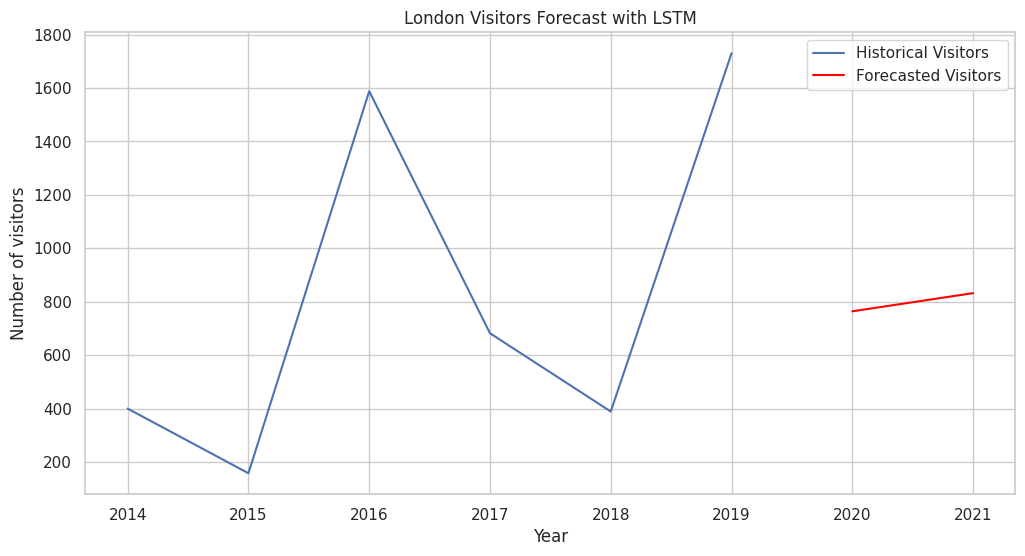

London will have 764 visitors in the year 2020.
London will have 832 visitors in the year 2021.


In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt



# Group by 'u_city' and calculate the total number of visitors
city_data = raw.groupby('u_city')['owner'].count()


# Identify the city with the maximum number of photos
max_photo_city = city_data.idxmax()

# Filter data for the city with the maximum number of photos
max_photo_city_data = raw[raw['u_city'] == max_photo_city]

# Convert 'taken' to datetime
max_photo_city_data['taken'] = pd.to_datetime(max_photo_city_data['taken'])

# Extract the year from 'taken'
max_photo_city_data['year'] = max_photo_city_data['taken'].dt.year

# Group by 'u_city', 'year', and calculate the count of 'photo_id'
result = max_photo_city_data.groupby(['u_city', 'year'])['owner'].count().reset_index()

# Rename the count column to 'total_num_of_photos'
result = result.rename(columns={'owner': 'total_num_of_visitors'})

# Normalize the data
scaler = MinMaxScaler()
result['total_num_of_visitors_scaled'] = scaler.fit_transform(result['total_num_of_visitors'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into (samples, time_steps, features)
time_steps = 1
X, y = create_dataset(result['total_num_of_visitors_scaled'].values.reshape(-1, 1), time_steps)

X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1, time_steps)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

# Predict future values
future_steps = 2
forecast_input = result['total_num_of_visitors_scaled'].values[-time_steps:]
forecast_input = forecast_input.reshape((1, 1, time_steps))

forecast = []

for i in range(future_steps):
    prediction = model.predict(forecast_input, verbose=0)
    forecast.append(prediction[0, 0])
    forecast_input = np.append(forecast_input[:, 0, 1:], prediction[0])
    forecast_input = forecast_input.reshape((1, 1, time_steps))

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(result['year'], result['total_num_of_visitors'], label='Historical Visitors')
plt.plot(range(result['year'].max() + 1, result['year'].max() + 1 + future_steps), forecast, color='red', label='Forecasted Visitors')
plt.title(f'{max_photo_city} Visitors Forecast with LSTM')
plt.xlabel('Year')
plt.ylabel('Number of visitors')
plt.legend()
plt.grid(True)
plt.show()

# Display the forecasted values
forecasted_values = pd.DataFrame({
    'Year': range(result['year'].max() + 1, result['year'].max() + 1 + future_steps),
    'City': [max_photo_city] * future_steps,
    'Forecasted Visitors': forecast.flatten()
})

# Print the forecasted values
for year, visitors in zip(forecasted_values['Year'], forecasted_values['Forecasted Visitors']):
    print(f"{max_photo_city} will have {int(visitors)} visitors in the year {int(year)}.")


In [52]:
from sklearn.metrics import mean_absolute_error

# Actual values for the forecasted years
actual_values = np.array([result['total_num_of_visitors'].max() + i for i in range(1, future_steps + 1)])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast.flatten())
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Efficiency (percentage of accuracy)
efficiency = 100 * (1 - mae / result['total_num_of_visitors'].max())
print(f'Efficiency: {efficiency:.2f}%')


Mean Absolute Error (MAE): 933.3494873046875
Efficiency: 46.05%


**ARIMA**

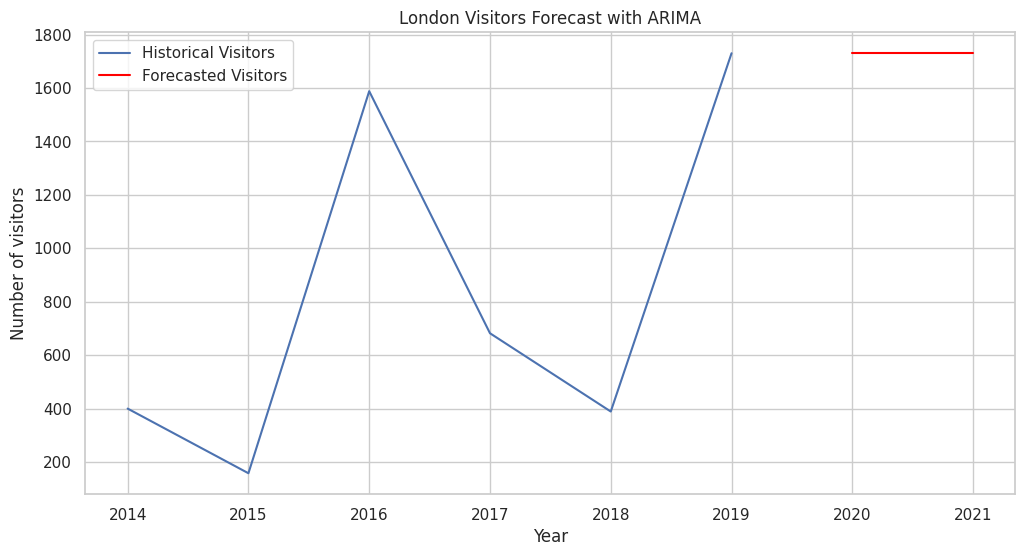

London will have 1730.0059008525216 visitors in the year 2020.


In [55]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt



# Group by 'u_city' and calculate the total number of visitors
city_data = raw.groupby('u_city')['owner'].count()

# Identify the city with the maximum number of photos
max_photo_city = city_data.idxmax()

# Filter data for the city with the maximum number of photos
max_photo_city_data = raw[raw['u_city'] == max_photo_city]

# Convert 'taken' to datetime if it's not already
max_photo_city_data['taken'] = pd.to_datetime(max_photo_city_data['taken'])

# Extract the year from 'taken'
max_photo_city_data['year'] = max_photo_city_data['taken'].dt.year

# Group by 'u_city', 'year' and calculate the count of 'owner'
result = max_photo_city_data.groupby(['u_city', 'year'])['owner'].count().reset_index()

# Rename the count column to 'total_num_of_visitors'
result = result.rename(columns={'owner': 'total_num_of_visitors'})

# Fit an ARIMA model
order = (1, 1, 1)  # ARIMA order (p, d, q)
model = ARIMA(result['total_num_of_visitors'], order=order)
results = model.fit()

# Forecast future photos
forecast_steps = 2  # Adjust the number of forecast steps as needed
forecast = results.get_forecast(steps=forecast_steps).predicted_mean

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(result['year'], result['total_num_of_visitors'], label='Historical Visitors')
plt.plot(range(result['year'].max() + 1, result['year'].max() + 1 + forecast_steps), forecast, color='red', label='Forecasted Visitors')
plt.title(f'{max_photo_city} Visitors Forecast with ARIMA')
plt.xlabel('Year')
plt.ylabel('Number of visitors')
plt.legend()
plt.grid(True)
plt.show()

# Display the forecasted values
forecasted_values = pd.DataFrame({
    'Year': range(result['year'].max() + 1, result['year'].max() + 1 + forecast_steps),
    'City': [max_photo_city] * forecast_steps,
    'Forecasted Visitors': forecast
})

# Print the forecasted values
print(f"{max_photo_city} will have {forecasted_values['Forecasted Visitors'].iloc[0]} visitors in the year {forecasted_values['Year'].iloc[0]}.")


In [56]:
from sklearn.metrics import mean_absolute_error

# Actual values for the forecasted years
actual_values = np.array([result['total_num_of_visitors'].max() + i for i in range(1, forecast_steps + 1)])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Efficiency (percentage of accuracy)
efficiency = 100 * (1 - mae / result['total_num_of_visitors'].max())
print(f'Efficiency: {efficiency:.2f}%')


Mean Absolute Error (MAE): 1.4940991409869184
Efficiency: 99.91%
